<a href="https://colab.research.google.com/github/yrodriguezmd/IceVision_miniprojects/blob/main/02_object_detection__fasterrcnn%2C_yolo5%2C_retinanet%2C_effdet_2021_8_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

print(torch.__version__)
print(torchvision.__version__)

--2021-08-23 13:18:21--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1244 (1.2K) [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]   1.21K  --.-KB/s    in 0s      

2021-08-23 13:18:21 (55.8 MB/s) - ‘install_colab.sh’ saved [1244/1244]

Installing icevision + dependencices for CUDA 10
Uninstalling some dependencies to prevent errors
Found existing installation: torchvision 0.10.0+cu102
Uninstalling torchvision-0.10.0+cu102:
  Successfully uninstalled torchvision-0.10.0+cu102
Found existing installation: fastai 1.0.61
Uninstalling fastai-1.0.61:
  Successfully uninstalled fastai-1.0.61
Installing some dependencies to prevent errors
     |██

In [ ]:
from icevision.all import *
import icedata
import icevision
print(icevision.__version__)

path = icedata.pets.load_data()

class_map = icedata.pets.class_map()

data_splitter = RandomSplitter([0.8, 0.2])

parser = icedata.pets.parser(data_dir=path)# removed mask

train_records, valid_records = parser.parse(data_splitter)

0.8.1


  0%|          | 0/3686 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/2948 [00:00<?, ?it/s]

  0%|          | 0/738 [00:00<?, ?it/s]

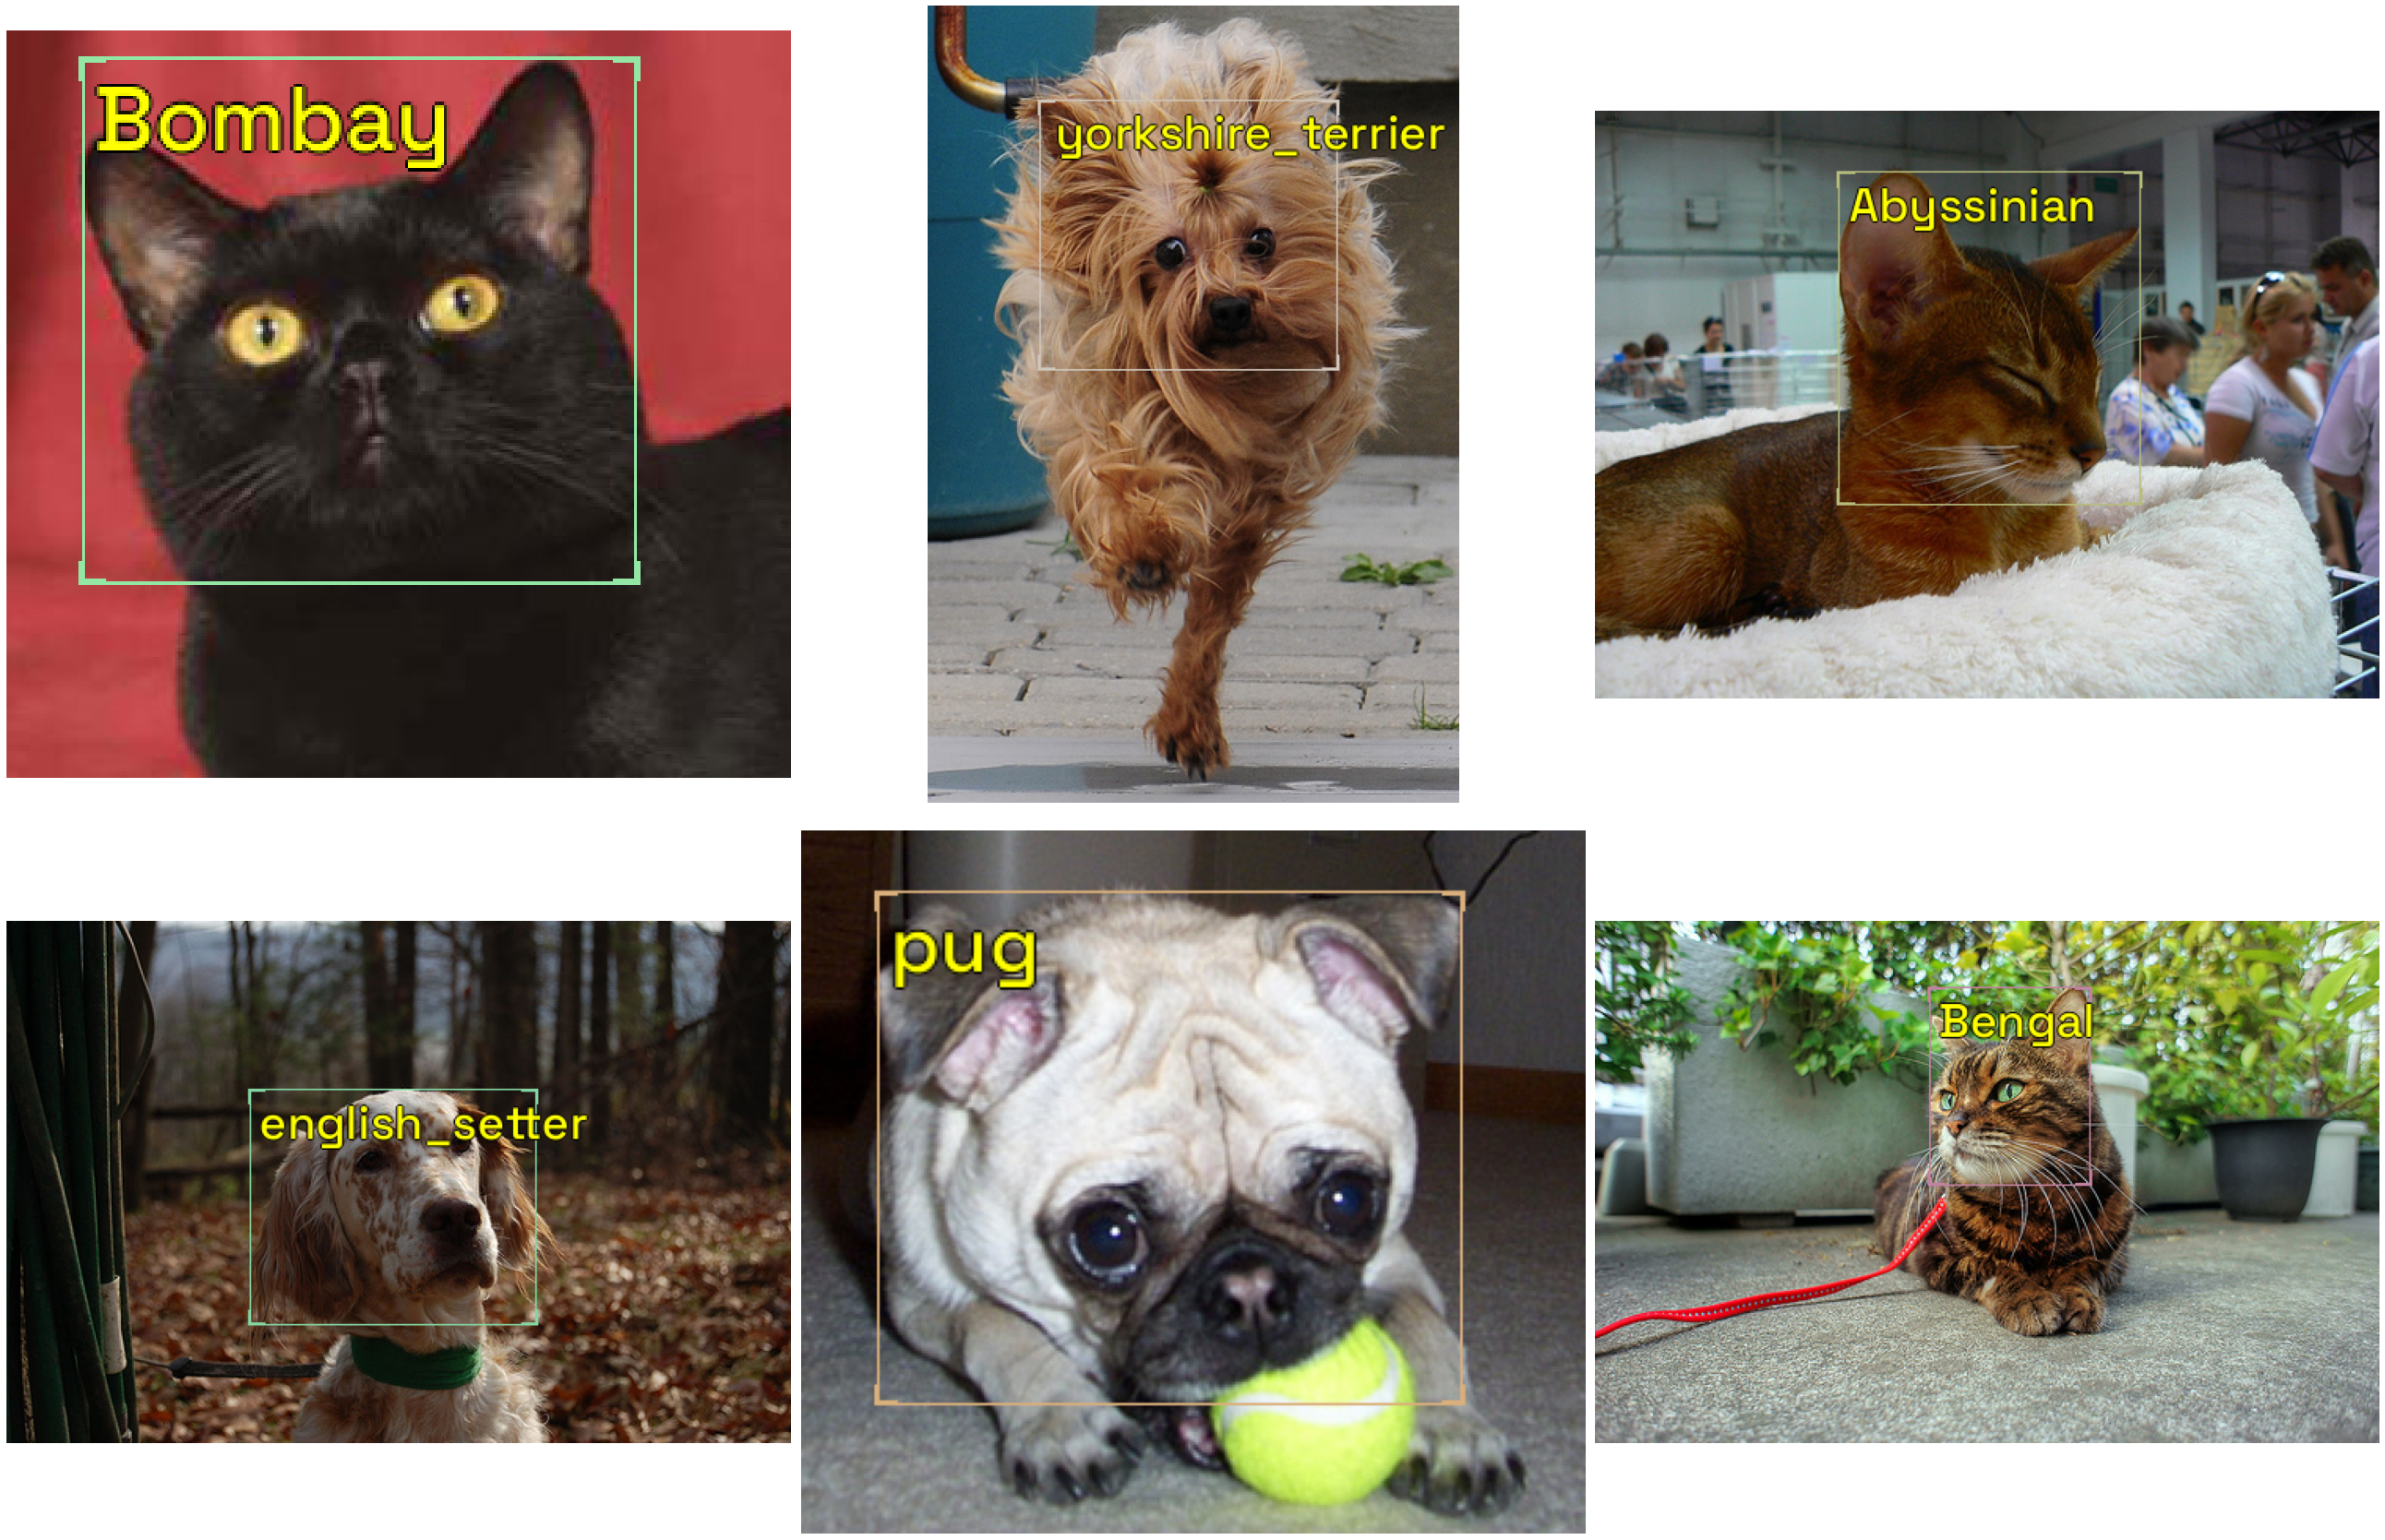

In [ ]:
show_records(train_records[3:9], ncols=3, 
             class_map=class_map, show=True,
             #label_color = '#c1c1c7', #whitish purple
             #label_color = '#020303', # black
            label_color = '#ffff00', # yellow
            # label_color = '#0000ff', # blue
              #label_color = '#00ff00', #  green             
             #label_color = '#25ff50', # lt green
             font_size = 30, prettify = False)

In [ ]:
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
# using faster rcnn: 2-stage
model_type_frcnn = models.torchvision.faster_rcnn ##
#backbone = model_type_ret.backbones.resnet50_fpn_1x(pretrained=True)#
model_frcnn = model_type_frcnn.model( ##
                      num_classes=len(parser.class_map))
train_dl_frcnn = model_type_frcnn.train_dl(train_ds, ##
                      batch_size=16, num_workers=4, shuffle=True)
valid_dl_frcnn = model_type_frcnn.valid_dl(valid_ds, ##
                      batch_size=16, num_workers=4, shuffle=False)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=3.0199516913853586e-05)

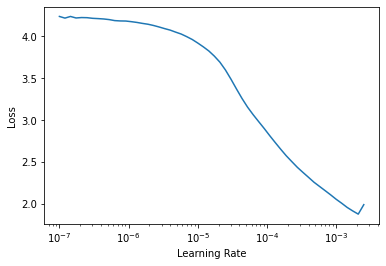

In [ ]:
learn_frcnn = model_type_frcnn.fastai.learner(dls=[train_dl_frcnn, ###
                                                   valid_dl_frcnn], #
                                              model=model_frcnn, metrics=metrics)#
learn_frcnn.lr_find()#

In [ ]:
# use visual clue
# using lr_min leads to immediately high mAP,
#   but also high valid_loss

In [ ]:
#### side project fine_tune cumulative?

In [ ]:
learn_frcnn.fine_tune(10, 0.00021, freeze_epochs=1) #

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics(learn, title, x, y):
  plt.plot(L(learn.recorder.values).itemgot())#
  plt.xlabel('epoch')
  plt.ylabel('mAP (green), Loss (blue, orange)')
  plt.title(title)
  plt.text(x, y, 'Legend: mAP(green), train_loss(blue), valid_loss(orange');

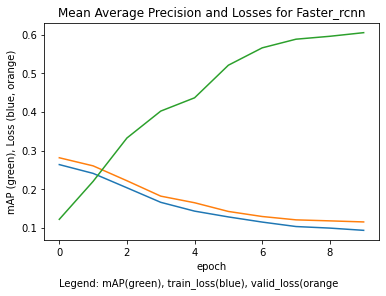

In [ ]:
plot_metrics(learn_frcnn, 'Mean Average Precision and Losses for Faster_rcnn', 0,-0.05)

  0%|          | 0.00/14.1M [00:00<?, ?B/s]

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=7.585775847473997e-07)

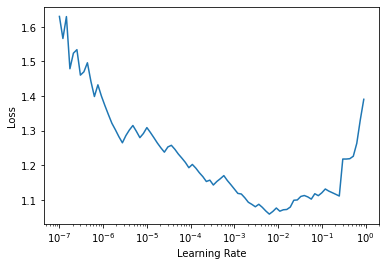

In [ ]:
# using YOLOv5: 1-stage
model_type_yolo = models.ultralytics.yolov5 ##
backbone_yolo = model_type_yolo.backbones.small #
model_yolo = model_type_yolo.model(backbone = backbone_yolo(pretrained=True), ###
                      num_classes=len(parser.class_map),
                      img_size = image_size)#
train_dl_yolo = model_type_yolo.train_dl(train_ds, ##
                      batch_size=16, num_workers=4, shuffle=True)
valid_dl_yolo = model_type_yolo.valid_dl(valid_ds, ##
                      batch_size=16, num_workers=4, shuffle=False)
                                       
learn_yolo = model_type_yolo.fastai.learner(dls=[train_dl_yolo, ###
                                                   valid_dl_yolo], #
                                              model=model_yolo, metrics=metrics)#
learn_yolo.lr_find()#

In [ ]:
learn_yolo.fine_tune(10, 0.00063, freeze_epochs=1) #

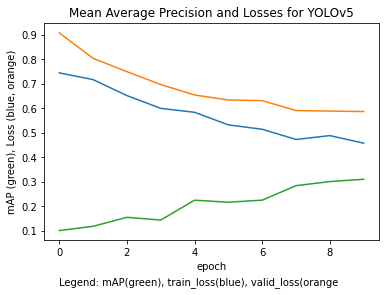

In [ ]:
plot_metrics(learn_yolo, 'Mean Average Precision and Losses for YOLOv5', 0,-0.12)

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/utils/weight_init.py:119: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  'init_cfg without layer key, if you do not define override'


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([333, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([333]).


SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=0.0002754228771664202)

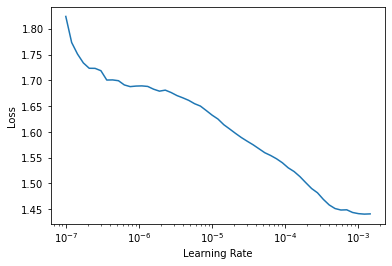

In [ ]:
# using retinanet/ resnet50: focal loss
model_type_ret = models.mmdet.retinanet #
backbone_r50 = model_type_ret.backbones.resnet50_fpn_1x(pretrained=True)#
model_ret = model_type_ret.model(backbone=backbone_r50(pretrained=True), #
                      num_classes=len(parser.class_map))

train_dl_ret = model_type_ret.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)#
valid_dl_ret = model_type_ret.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)#

learn_ret = model_type_ret.fastai.learner(dls=[train_dl_ret, valid_dl_ret], model=model_ret, metrics=metrics)#
learn_ret.lr_find()#
# use ***

In [ ]:
learn_ret.fine_tune(10, 0.00012, freeze_epochs=1) #

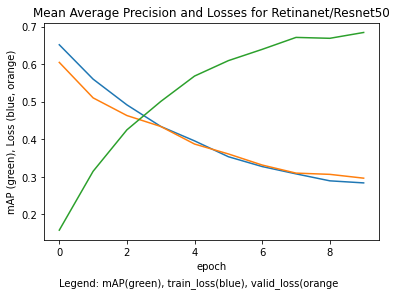

In [ ]:
 plot_metrics(learn_ret, 'Mean Average Precision and Losses for Retinanet/Resnet50', 0, 0.01)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_lite0-f5f303a9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_lite0-f5f303a9.pth


SuggestedLRs(lr_min=0.03630780577659607, lr_steep=3.311311274956097e-06)

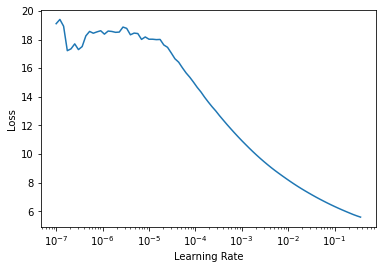

In [ ]:
# using efficientdet
model_type_eff = models.ross.efficientdet ##
backbone_eff = model_type_eff.backbones.tf_lite0#
model_eff = model_type_eff.model(backbone = backbone_eff(pretrained=True), ##
                      num_classes=len(parser.class_map),
                      img_size = image_size)#
train_dl_eff = model_type_eff.train_dl(train_ds, ##
                      batch_size=16, num_workers=4, shuffle=True)
valid_dl_eff = model_type_eff.valid_dl(valid_ds, ##
                      batch_size=16, num_workers=4, shuffle=False)
                                       
learn_eff = model_type_eff.fastai.learner(dls=[train_dl_eff, ###
                                                   valid_dl_eff], #
                                              model=model_eff, metrics=metrics)#
learn_eff.lr_find()#

In [ ]:
learn_eff.fine_tune(10, 0.036, freeze_epochs=1) #

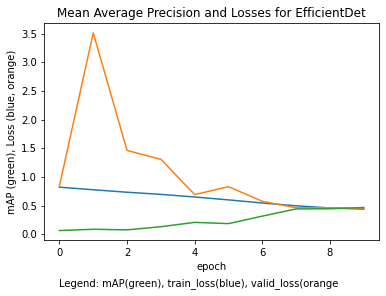

In [ ]:
plot_metrics(learn_eff, 'Mean Average Precision and Losses for EfficientDet',0,-0.9)

In [ ]:
## Findings
- retnet at lr 0.00012 provided best map, losses
- plateau at epoch 8

In [ ]:
# using retinanet/ resnet50: focal loss
model_type_ret = models.mmdet.retinanet #
backbone_r50 = model_type_ret.backbones.resnet50_fpn_1x(pretrained=True)#
model_ret = model_type_ret.model(backbone=backbone_r50(pretrained=True), #
                      num_classes=len(parser.class_map))

train_dl_ret = model_type_ret.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)#
valid_dl_ret = model_type_ret.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)#

learn_ret = model_type_ret.fastai.learner(dls=[train_dl_ret, valid_dl_ret], model=model_ret, metrics=metrics)#
#learn_ret.lr_find()#
## if don't restart, starts at high map --> accumulated?

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/utils/weight_init.py:119: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  'init_cfg without layer key, if you do not define override'


Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([333, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([333]).


In [ ]:
## rerun best model, good epoch ###
learn_ret.fine_tune(8, 0.00012, freeze_epochs=1) #

In [ ]:
# inference
!pip install bing-image-downloader
from bing_image_downloader import downloader
query_string = 'wiki samoyed'
samo = downloader.download(query_string, limit = 3, 
                            output_dir = 'dataset',
                            adult_filter_off=True,
                            force_replace=False,
                            timeout=60,
                            verbose=True)
samo

[%] Downloading Images to /content/dataset/wiki samoyed


[!!]Indexing page: 1

[%] Indexed 3 Images on Page 1.


[%] Downloading Image #1 from http://upload.wikimedia.org/wikipedia/commons/0/09/Samoyed_on_snow.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://upload.wikimedia.org/wikipedia/commons/c/c4/Samoyed-sweetjedysamoyeds.jpg
[%] File Downloaded !

[%] Downloading Image #3 from http://pratatnevies.fun/xwwmsb/A7JAKxcFAfH1sHGFUxAt5AHaHk.jpg
[%] File Downloaded !



[%] Done. Downloaded 3 images.

Please show your support here
https://www.buymeacoffee.com/gurugaurav




  0%|          | 0/44911 [00:00<?, ?B/s]

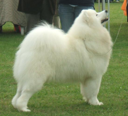

In [ ]:
url = ['https://upload.wikimedia.org/wikipedia/commons/c/c4/Samoyed-sweetjedysamoyeds.jpg']
dest = 'Desktop'
download_url(url[0],dest) #

from PIL import Image

image = Image.open(dest)
image.to_thumb(128)

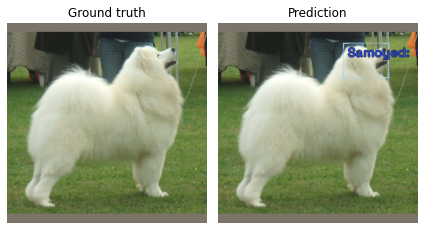

In [ ]:
img = np.array(image)

infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])

infer = Dataset.from_images([img], infer_tfms, class_map=class_map )#

# preds = model_type.predict(model, infer, keep_images=True)
preds = model_type_ret.predict(model_ret, infer, keep_images=True)##

show_preds(preds=preds, font_size=25,
                        label_color = '#3050ff', # blue

)

Further attempts to adjust font size, colour.  Still to figure out adjusting thickness of bbox.  Issue submitted to IceVision.

In [ ]:
def predict(
    model: nn.Module,
    dataset: Dataset,
    detection_threshold: float = 0.5,
    keep_images: bool = False,
    device: Optional[torch.device] = None,
) -> List[Prediction]:
    batch, records = build_infer_batch(dataset)
    return _predict_batch(
        model=model,
        batch=batch,
        records=records,
        detection_threshold=detection_threshold,
        keep_images=keep_images,
        device=device,
    )

In [ ]:
def show_results(
    model: nn.Module,
    dataset: Dataset,
    detection_threshold: float = 0.25,
    nms_iou_threshold: float = 0.45,
    num_samples: int = 6,
    ncols: int = 3,
    denormalize_fn: Optional[callable] = denormalize_imagenet,
    show: bool = True,
    device: Optional[torch.device] = None,
    **draw_sample_kwargs, ## added, for poss PR

) -> None:
    return base_show_results(
        predict_fn=predict,
        model=model,
        dataset=dataset,
        num_samples=num_samples,
        ncols=ncols,
        denormalize_fn=denormalize_fn,
        show=show,
        detection_threshold=detection_threshold,
        nms_iou_threshold=nms_iou_threshold,
        device=device,
    )

In [ ]:
#image_size = 384
#train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
#valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

#train_ds = Dataset(train_records, train_tfms)
#valid_ds = Dataset(valid_records, valid_tfms)

#valid_dl_ret = model_type_ret.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)#


In [ ]:
#img = np.array(image)

#infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])

#infer_valid_ds = Dataset.from_images([img], valid_ds, class_map=class_map )#

# preds = model_type.predict(model, infer, keep_images=True)
preds_val = model_type_ret.predict(model_ret, valid_dl_ret,) #keep_images=True)##

show_preds(preds=preds_val, font_size=25,
                       #label_color = '#ffff00', # yellow
                        label_color = '#3050ff', # blue
                        ncols=3
)

AttributeError: ignored

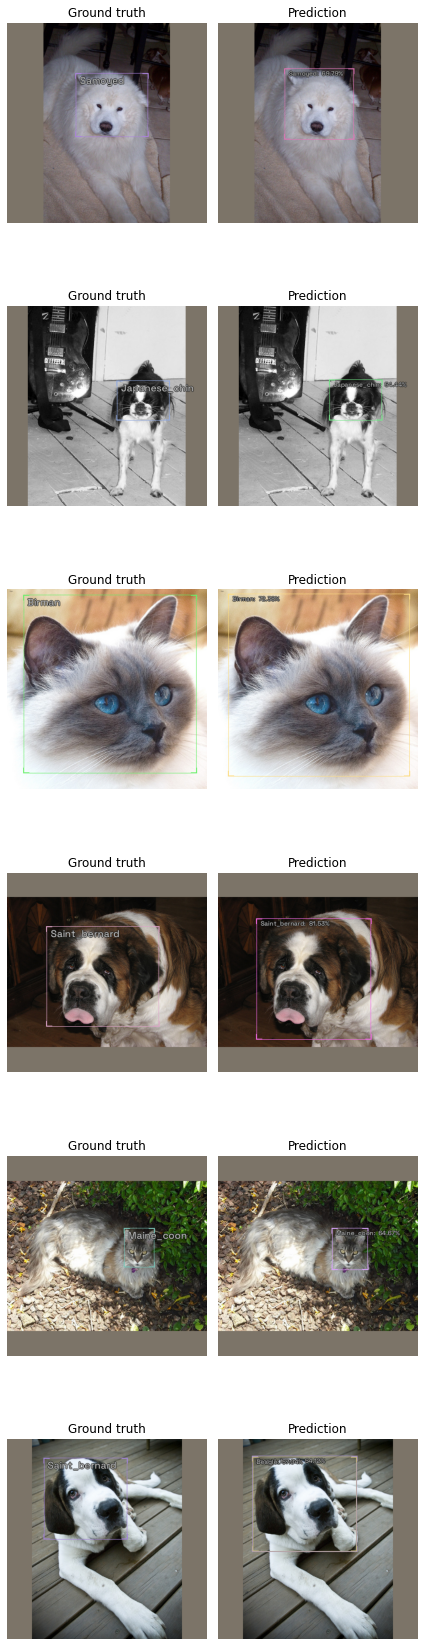

In [ ]:
# default detection_threshold = 0.25
model_type_ret.show_results(model_ret, valid_ds, 
                #font_size = 30,  
                 #label_color = '#25ff50', # lt green)

In [ ]:
# default detection_threshold = 0.25
model_type_ret.show_results(model_ret, valid_ds, 
                font_size = 30,  
                 label_color = '#25ff50', # lt green
)

TypeError: ignored

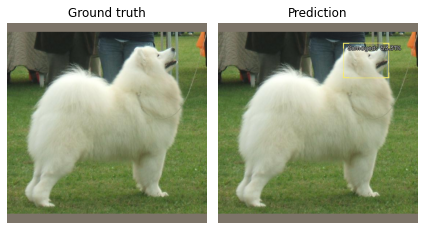

In [ ]:
img = np.array(image)

infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=384), tfms.A.Normalize()])

infer = Dataset.from_images([img], infer_tfms, class_map=class_map )#

# preds = model_type.predict(model, infer, keep_images=True)
preds = model_type_ret.predict(model_ret, infer, keep_images=True)##

show_preds(preds=preds)